# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Pymc3 Regression
Week 8 | Lab 5.2

In [2]:
from __future__ import print_function, division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

## 'Bayesian Regression' using pymc3

We can use the same kind of model setup we studied for t-testing to perform Bayesian-style regressions as well. 

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of APM means per group yesterday, when we perform regression with Bayesian statistics we will get out posterior distributions - this time on our **intercept** and **coefficients**. This makes it easy to see the entire distribution of possibilities for these coefficients and shows us immediately the degree of uncertainty in our estimate. Whereas in the more standard approach, we simply return the line of best fit and then afterwards must assess how optimal the fit is based on other metrics (which we might forget to do, it not being an inherent part of the process). Additionally, we can input our own knowledge including priors that represent our beliefs on the bounds of an appropriate fit.

Remember - when we perform linear regression we are minimising some loss function (generally mean squared error).

In [18]:
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, 200)
true_regression_line = true_intercept + true_slope * x
# y = mx + c + error
y = true_regression_line + np.random.normal(scale=.5, size=200)
data = pd.DataFrame(data=dict(x=x, y=y))

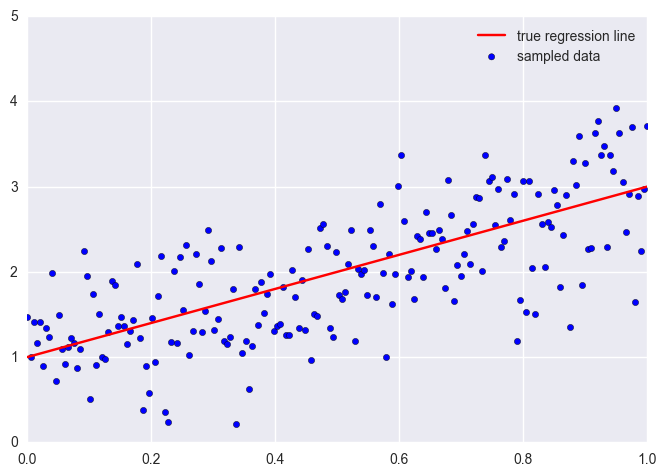

In [19]:
plt.scatter(x, y, label='sampled data')
plt.plot(x, true_regression_line, label='true regression line', c="r")
plt.legend(loc=0)
plt.xlim([0,1])
plt.ylim([0,5])
plt.show()

In [42]:
# glm is generalised linear model and mimics the syntax used in R / statsmodels
# the default MCMC algorithm is NUTS but I have used Metropolis-Hastings here
# so that it matches what we discussed in the previous lab (NUTS is more efficient)
# this way of setting up the regression makes various assumptions that are not 
# explicitly stated: such as that the priors are Gaussian/Normal

linear_model=pm.Model()

with linear_model:
    pm.glm.glm('y ~ x', data)
    step = pm.Metropolis()
    trace = pm.sample(5000, step)

# cut off the first 2000 trace samples out of the total
burned_trace=trace[2000:]

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 5000/5000 [00:01<00:00, 2948.24it/s]


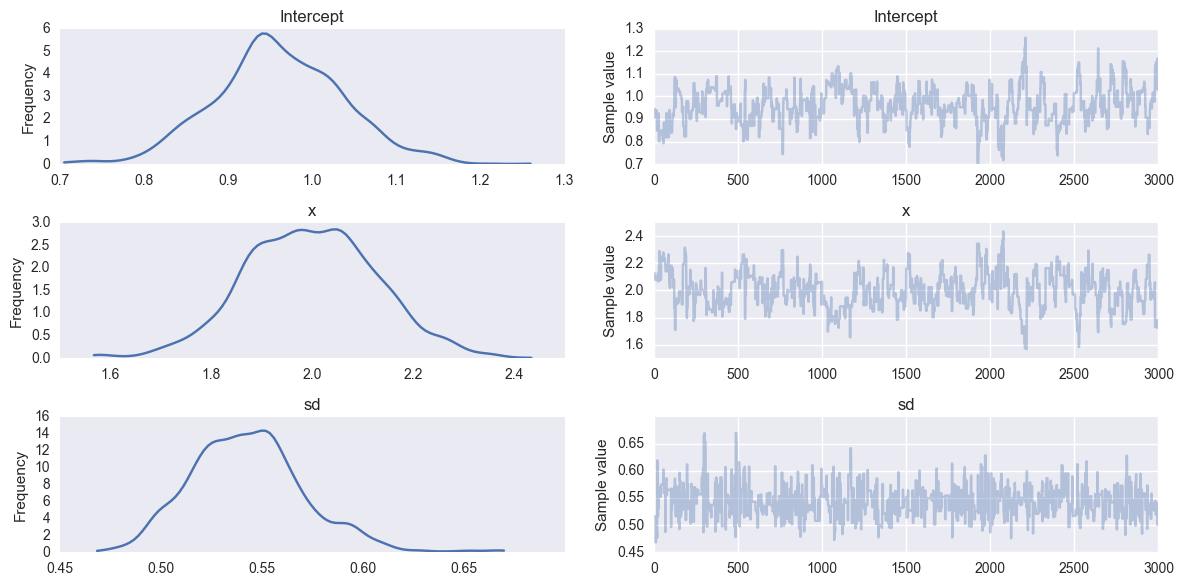

In [43]:
# Let's get a visual output of our trace to see our values and their spread

pm.traceplot(burned_trace)
plt.tight_layout()
plt.show()

What is the above plot telling us? 

For the left hand side: for every parameter (intercept, the 'm'-coefficient in front of the x, the standard deviation on the noise) we have some range of possible values based
on our random sampling comparisons of likelihoods as we span the hypothesis space of possible values for these parameters (the x-axis of each of the plots on the left hand side). Hence these are posteriors of each parameter. The peak represents the maximum posterior estimate, and you can verify yourself that these are very close to the values used to generate the data.

For the right hand side: this is the sampling chain. This tells us the stability of the sampling (the y axis here corresponds to the x-axis of the left-hand plot, and the x-axis then is the sequence number of the sample in the 'trace' object which holds all our samples).

The above is the burned_trace which discards the initial points, which were based on a random initialisation. It is also informative to view the full trace and see how the sampling had varied from the start of the MCMC.

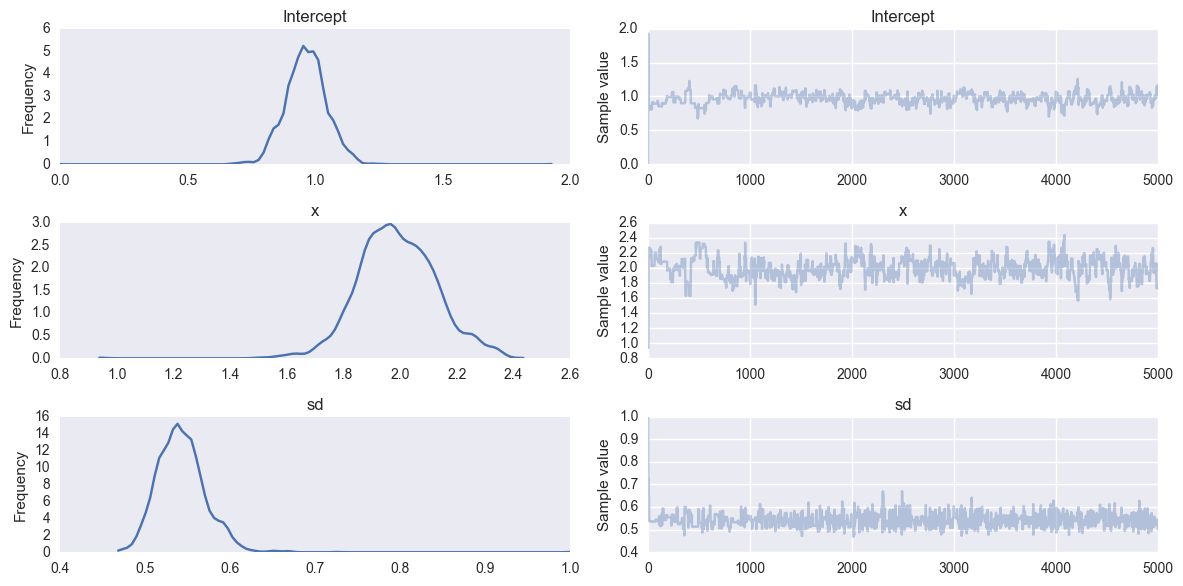

In [44]:
# Just for interest, viewing the full trace of samples taken

pm.traceplot(trace)
plt.tight_layout()
plt.show()

(0, 5)

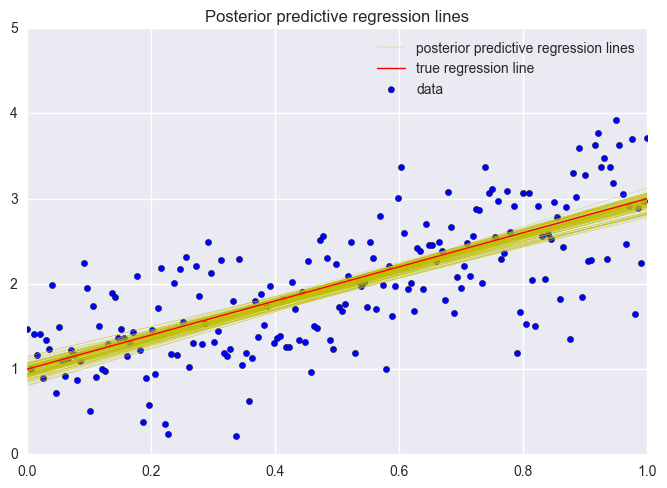

In [53]:
# This plot_posterior_predictive is a nice function to visualise your
# range of linear fits to the data - here you can really see your uncertainty
# in a way that is much less clear in a standard linear fit

plt.scatter(x, y, label='data')
pm.glm.plot_posterior_predictive(burned_trace, samples=100,
                              label='posterior predictive regression lines', c='y')
plt.plot(x, true_regression_line, label='true regression line', lw=1., c='r')
plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,5])
plt.show()

In [57]:
# Summary of the trace including the Highest Posterior Density 95% interval
# (often called the 'credible interval' - this makes explicit our uncertainty
# on each returned parameter)

pm.summary(burned_trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.960            0.077            0.006            [0.815, 1.119]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.815          0.912          0.955          1.013          1.119


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.997            0.131            0.010            [1.767, 2.272]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.735          1.904          1.995          2.085          2.264


sd:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

In [ ]:
# If we just want to return single values as in a standard regression
# we can access them from the trace

print("Maximum intercept value:")
print(burned_trace["Intercept"].mean())
print("Maximum 'm'-coefficient for the x:")
print(burned_trace["x"].mean())

In [71]:
# We can compare these to an sklearn linear regression

from sklearn.linear_model import LinearRegression
linear=LinearRegression()
linear.fit(data["x"].reshape(-1, 1),data["y"].values)
print(linear.intercept_)
print(linear.coef_)

0.97882890053
[ 1.96598081]


Do we expect these to be the same? No, this is a different fitting parameter. In sklearn we are performing a least squares regression (minimised squared errors on our residuals), whereas here we are maximising the likelihood of our coefficient values given priors that are Normal/Gaussian. Neither one is 'correct' - both are optimising differently.

In [8]:
heart = pd.read_csv('./assets/datasets/heart_disease.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [9]:
y = heart["chol"].values

## Perform your own Bayesian regression

Following the Bayesian regression code above, choose some predictors from the heart disease dataset and fit a regression model using pymc3.
Fit the same linear regression using sklearn. How do they compare? If you are comfortable with this simple setting, you can try explicitly setting the parameters for the priors and likelihoods. You can take a look at the pymc3 documentation for guidance and/or discuss this with instructors. Then you can adjust these and test the differences. Try to get used to the way things are set up in pymc3. It is designed to be intuitive to those who are faimilar with popular libraries such as sklearn.

Have a look also through the documentation in general [here](https://pymc-devs.github.io/pymc3/index.html) to get a sense of what else pymc3 can do. We look here at simple fits, but the advantages of the Bayesian approach may be more apparent to you from examples given of more complex cases than the simple linear fit. The guide _Bayesian Methods for Hackers_ has become a widely referenced resource amongst data scientists in the tech startup community, do take a look [here](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb). Another widely referenced guide is John Kruschke's book _Doing Bayesian Data Analysis_ [here](http://amzn.eu/5LLFC3W) (known as "the puppy book"). Note the reference in this book to Stan, a Python implementation of which - PyStan, see docs [here](https://pystan.readthedocs.io/en/latest/) - never really took off in popularity compared to its R implementation and has largely now been superseded by pymc.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11935aa50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1195affd0>], dtype=object)

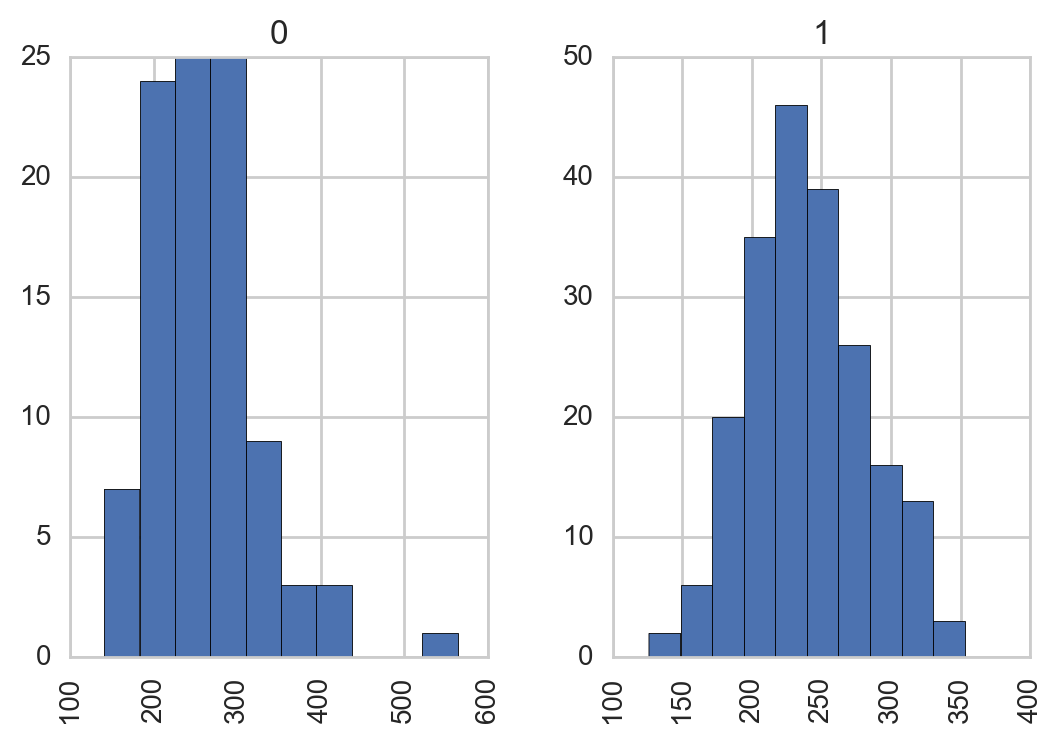

In [10]:
heart.hist(column='chol', by='sex')

In [11]:
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
print linreg.intercept_
print linreg.coef_

200.700171194
[  1.0956676  -20.08344167]


In [13]:
with pm.Model() as chol_simple:
    family = pm.glm.families.Normal()
    pm.glm.glm('chol ~ sex + age', heart, family=family)

Applied log-transform to sd and added transformed sd_log_ to model.


In [16]:
with chol_simple:
    step = pm.Metropolis()
    chol_trace = pm.sample(100000, step, progressbar=True)

 [-----------------100%-----------------] 100000 of 100000 complete in 31.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127bb5090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1285f2910>]], dtype=object)

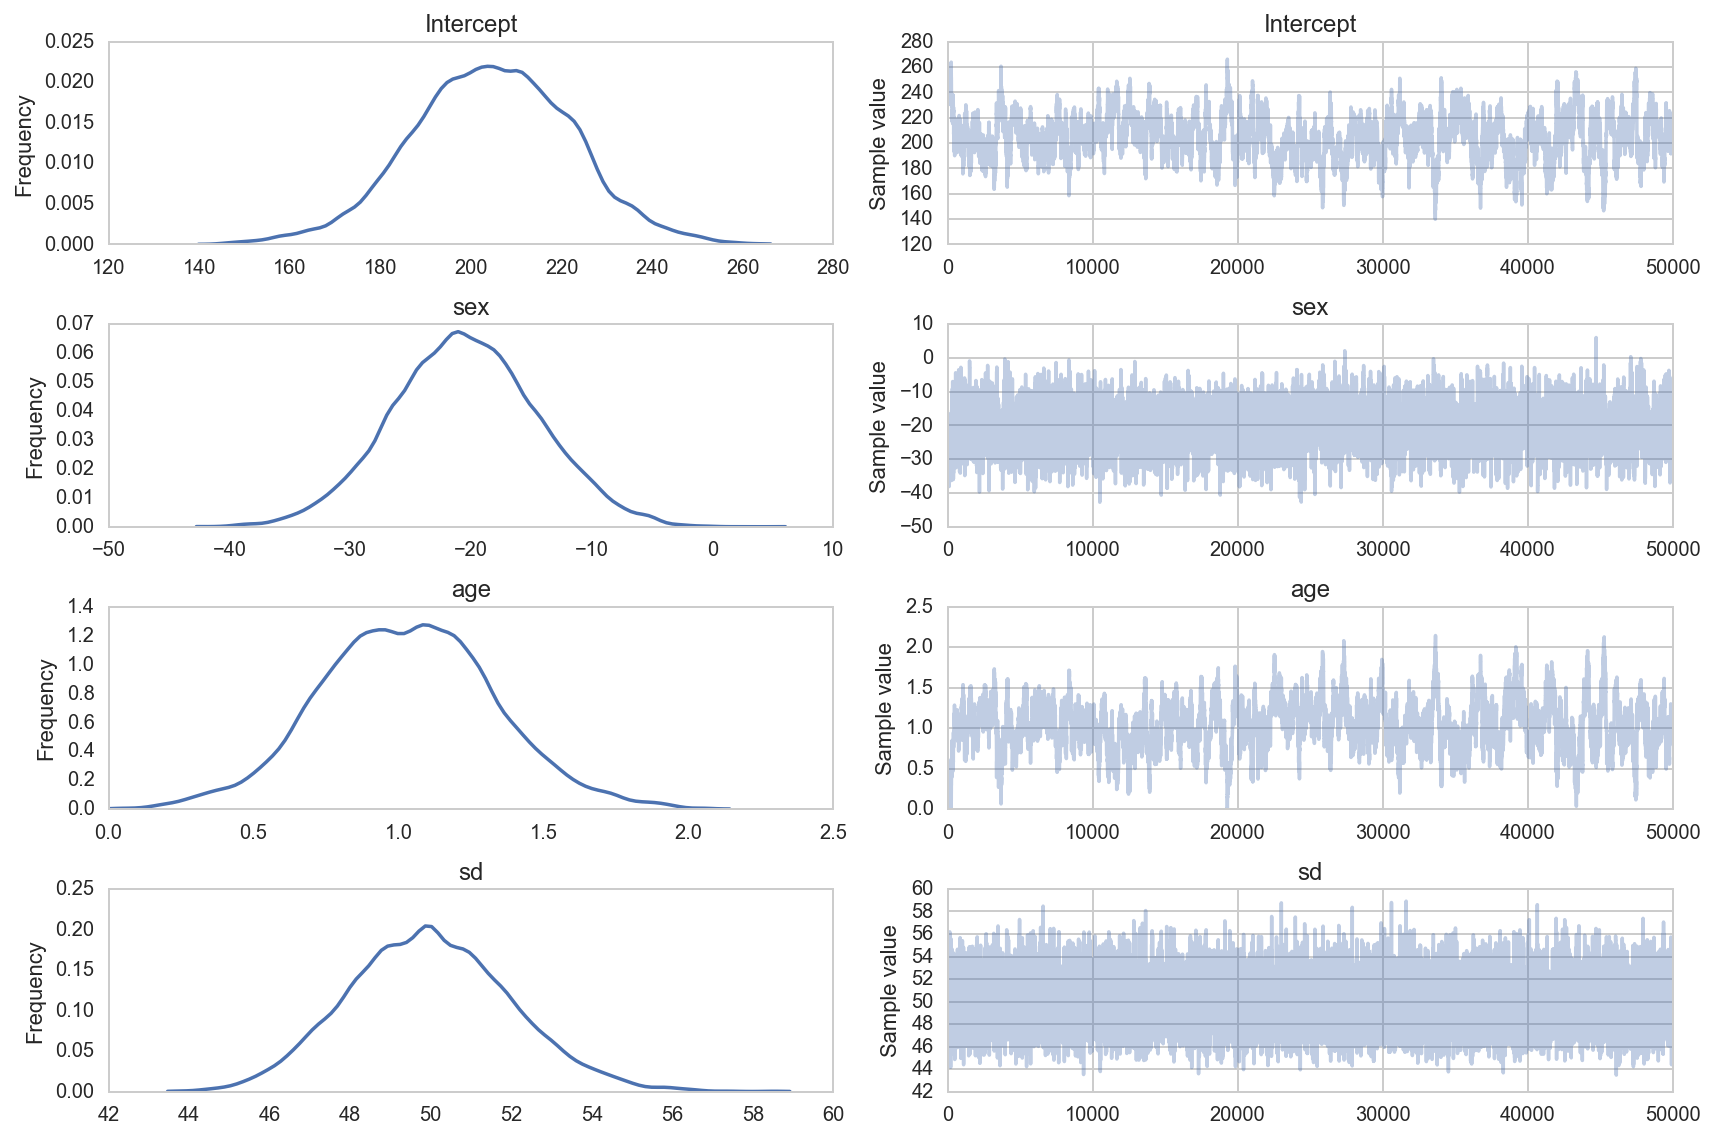

In [17]:
# take 2nd half of the "trace", which is the MCMC samples for the 
# different distributions. Cutting off the initial portion is good
# because it is often landing on bad/unlikely values at the beginning.
# This is called a "burn_in"
pm.traceplot(chol_trace[50000:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x128fc4810>], dtype=object)

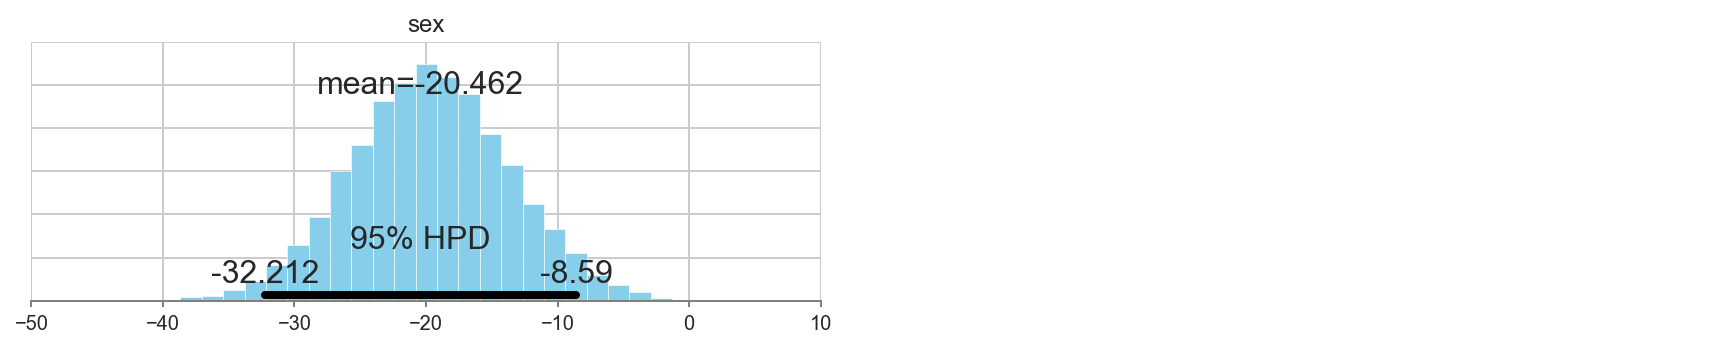

In [18]:
pm.plot_posterior(chol_trace[50000:], varnames=['sex'], color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x129114b90>], dtype=object)

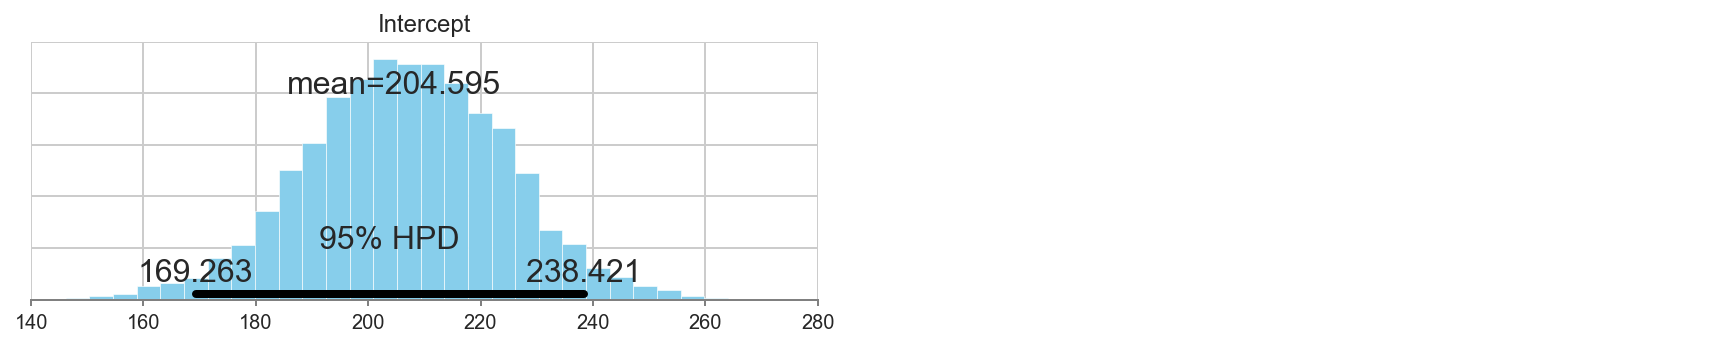

In [19]:
pm.plot_posterior(chol_trace[50000:], varnames=['Intercept'], color='#87ceeb')

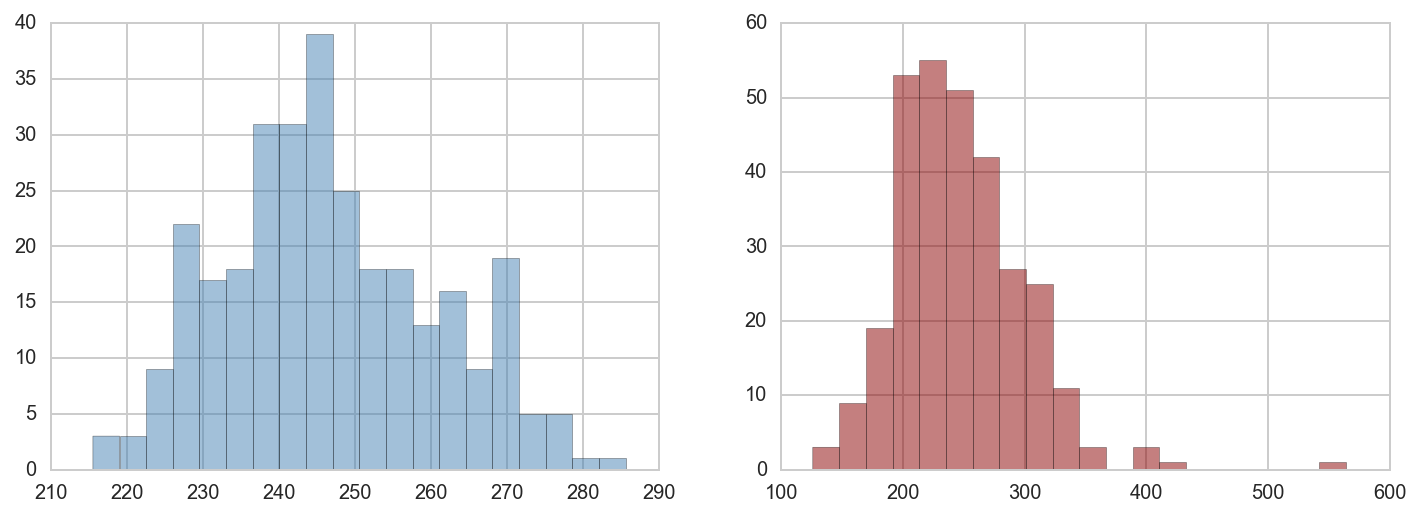

In [38]:
ppc = pm.sample_ppc(chol_trace[50000:], samples=1000, model=chol_simple)

ppc['y'].shape
yhat = np.mean(ppc['y'], axis=0)[0]

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(yhat, bins=20, color='steelblue', alpha=0.5)
ax[1].hist(heart.chol.values, bins=20, color='darkred', alpha=0.5)
plt.show()

In [27]:
heart.shape

(303, 14)

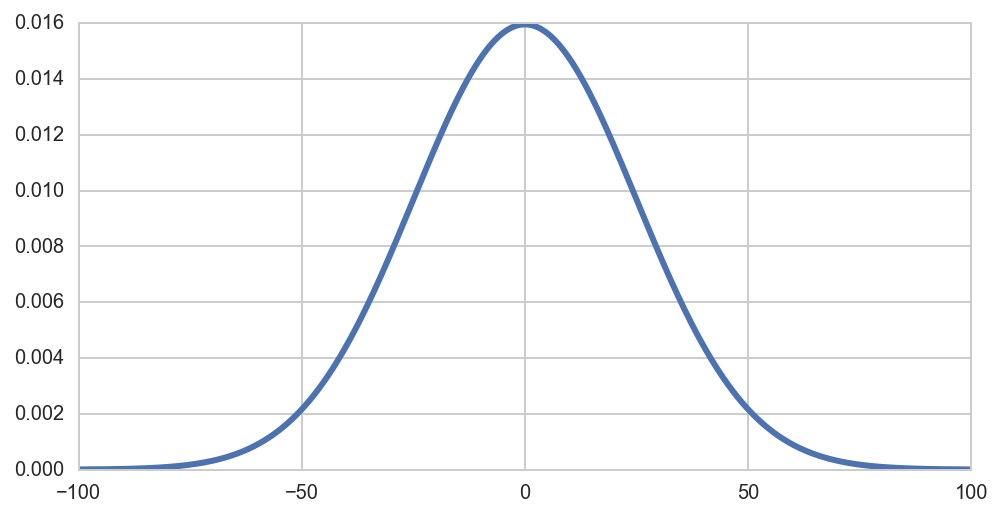

In [54]:
import scipy.stats as stats
int_pdf = stats.norm(loc=0, scale=25)
x_vals = np.linspace(-100, 100, 1000)
pdf_vals = int_pdf.pdf(x_vals)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_vals, pdf_vals, lw=3)
plt.show()

In [69]:
with pm.Model() as chol_manual:
    intercept = pm.Normal('intercept', mu=0, sd=10000)
    
    age_coef = pm.Normal('age_coef', mu=0, sd=10000)
    
    sex_coef = pm.Normal('sex_coef', mu=0, sd=10000.)
    
    chol_est = intercept + sex_coef*heart.sex.values + age_coef*heart.age.values
    
    model_error = pm.Uniform('model_error', lower=0, upper=heart.chol.std()*1000)
    chol_likelihood = pm.Normal('chol_like', mu=chol_est, sd=model_error, observed=heart.chol.values)
    

Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [70]:
with chol_manual:
    step = pm.Metropolis()
    trace = pm.sample(50000, step)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.1 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13101c590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13233a290>]], dtype=object)

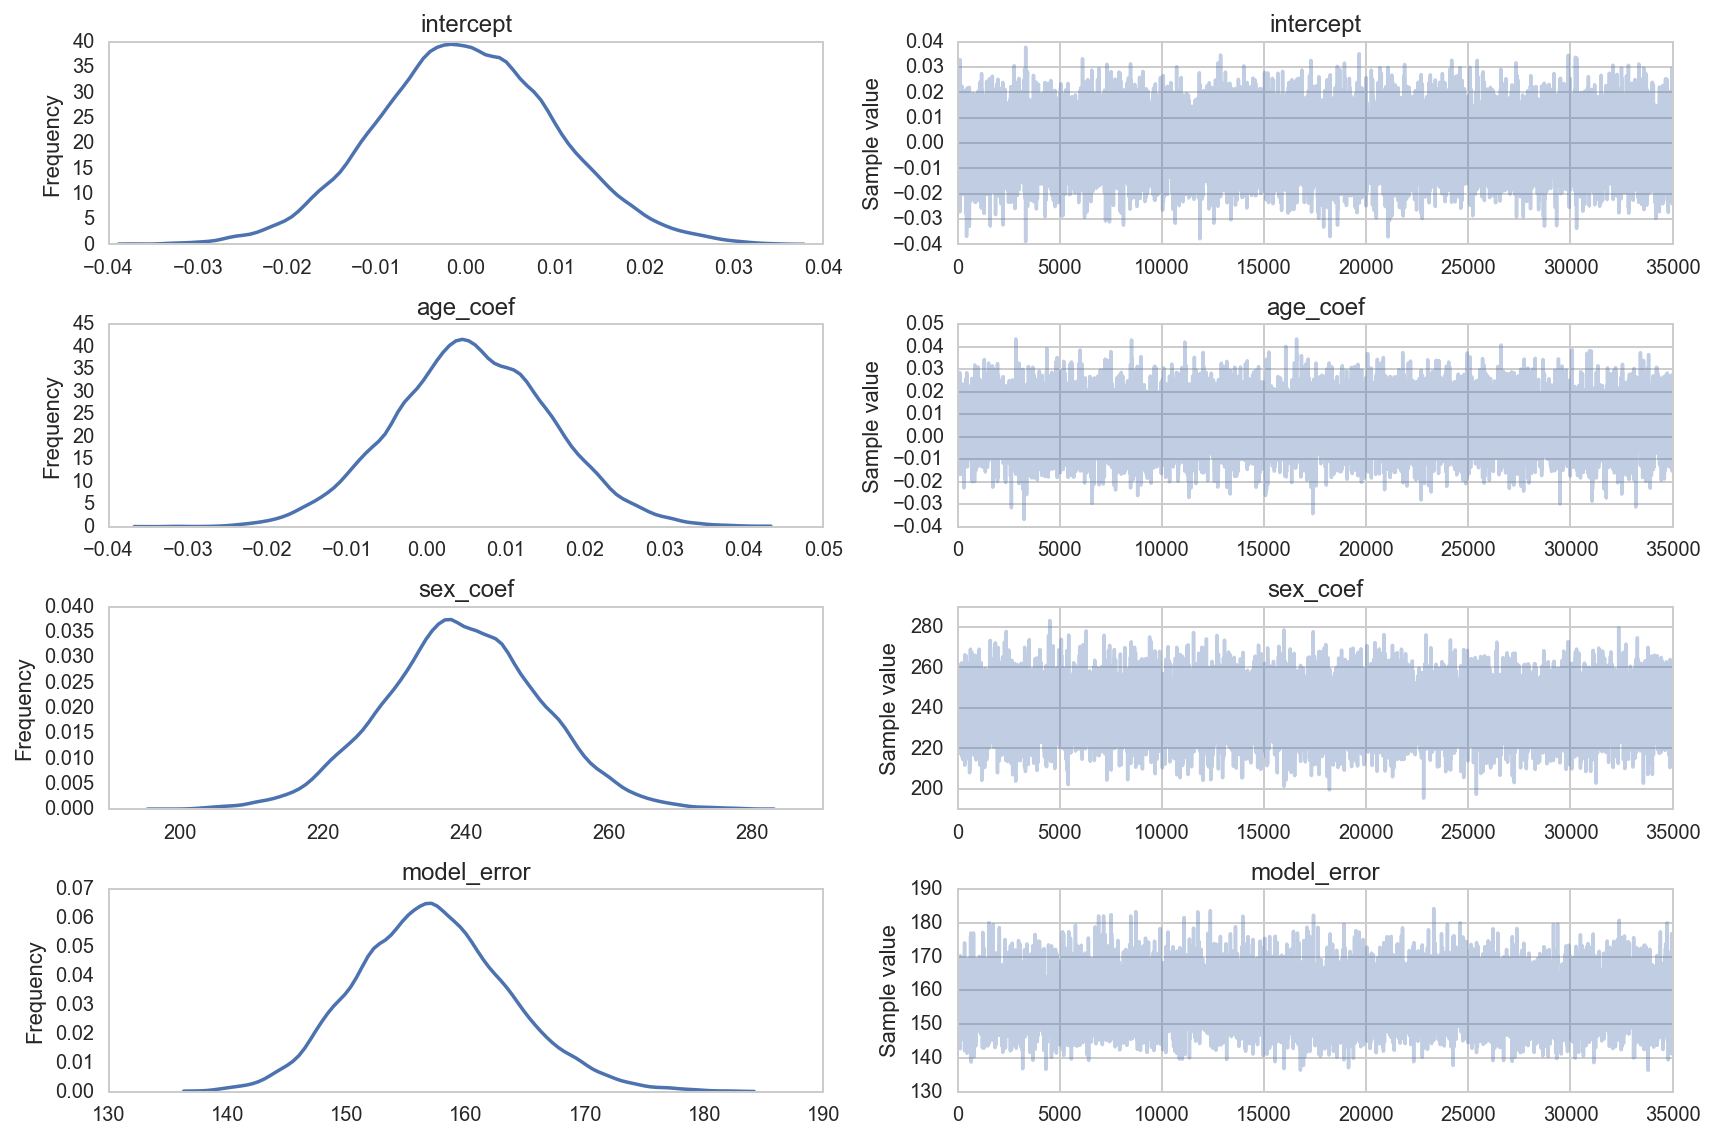

In [71]:
pm.traceplot(trace[15000:])

In [76]:
with chol_manual:
    print pm.find_MAP()

{'model_error_interval_': array(-8.761651084527795), 'intercept': array(0.00010340230349727661), 'sex_coef': array(239.28552420814142), 'age_coef': array(0.005870340117110867)}


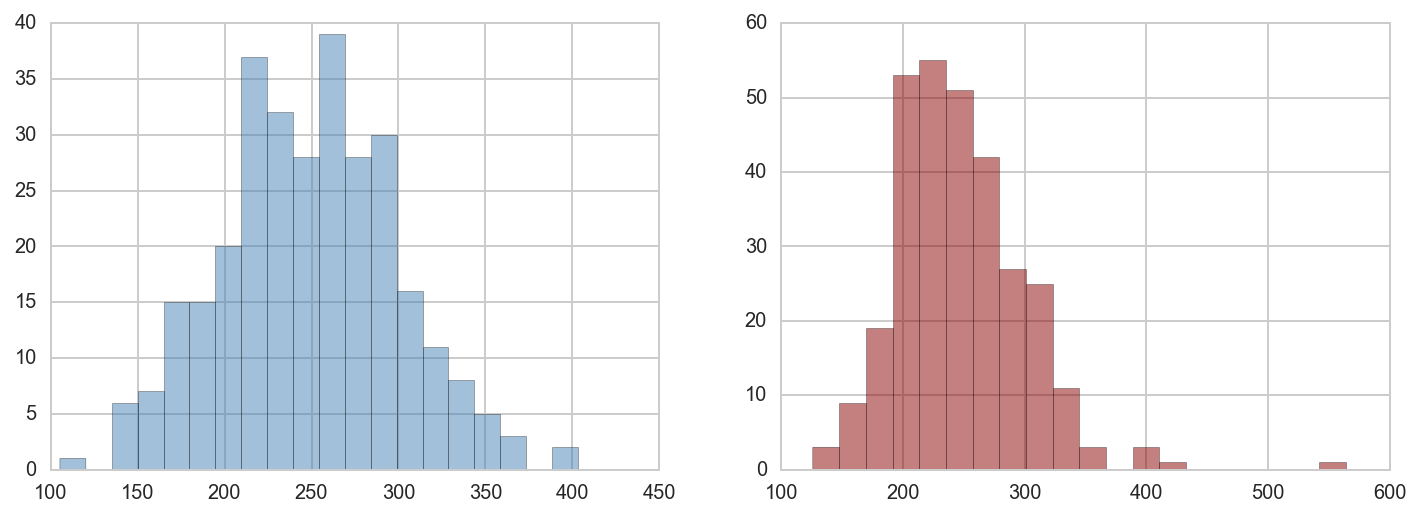

In [65]:
ppc = pm.sample_ppc(trace[15000:], samples=1, model=chol_manual)

ppc['chol_like'].shape
yhat = np.mean(ppc['chol_like'], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(yhat, bins=20, color='steelblue', alpha=0.5)
ax[1].hist(heart.chol.values, bins=20, color='darkred', alpha=0.5)
plt.show()

In [77]:
heart.columns

Index([u'age', u'sex', u'cp', u'trestbps', u'chol', u'fbs', u'restecg',
       u'thalach', u'exang', u'oldpeak', u'slope', u'ca', u'thal', u'num'],
      dtype='object')

In [78]:
heart.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2


In [ ]:
# model age by gender
# sklearn: chol ~ intercept + age + gender + age:gender
#

In [82]:
heart_females = heart[heart.sex == 1].index
heart_males = heart[heart.sex == 0].index
heart_mostly_female = heart.loc[heart_females | heart_males[0:10]]
print heart.shape, heart_mostly_female.shape

(303, 14) (216, 14)


In [83]:
with pm.Model() as age_by_gender:
    
    intercept = pm.Normal('intercept', mu=0, sd=1000.)
    female = pm.Normal('female', mu=0, sd=1000.)
    
    overall_age_mean = pm.Normal('overall_age_mean', mu=0, sd=1000.)
    overall_age_sd = pm.Uniform('overall_age_sd', lower=0, upper=10000.)
    
    age_by_gender_coefs = pm.Normal('age_by_gender',
                                    mu=overall_age_mean,
                                    sd=overall_age_sd,
                                    shape=len(heart_mostly_female.sex.unique()))
    
    # heart.sex.values = [1,1,0,1]
    # age_by_gender_coefs = [Normal_males, Normal_females]
    # age_by_gender_coefs[heart.sex.values] -->
    # --> [Normal_females, Normal_females, Normal_males, Normal_females]
    chol_est = (intercept +
                female*heart_mostly_female.sex.values +
                age_by_gender_coefs[heart_mostly_female.sex.values] * heart_mostly_female.age.values)
    
    model_error = pm.Uniform('model_error', lower=0, upper=10000)
    chol_like = pm.Normal('chol_like', mu=chol_est, sd=model_error,
                          observed=heart_mostly_female.chol.values)
    
    

Applied interval-transform to overall_age_sd and added transformed overall_age_sd_interval_ to model.
Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [84]:
with age_by_gender:
    step = pm.Metropolis()
    trace = pm.sample(150000, step)

 [-----------------100%-----------------] 150000 of 150000 complete in 80.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135562590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14636ccd0>]], dtype=object)

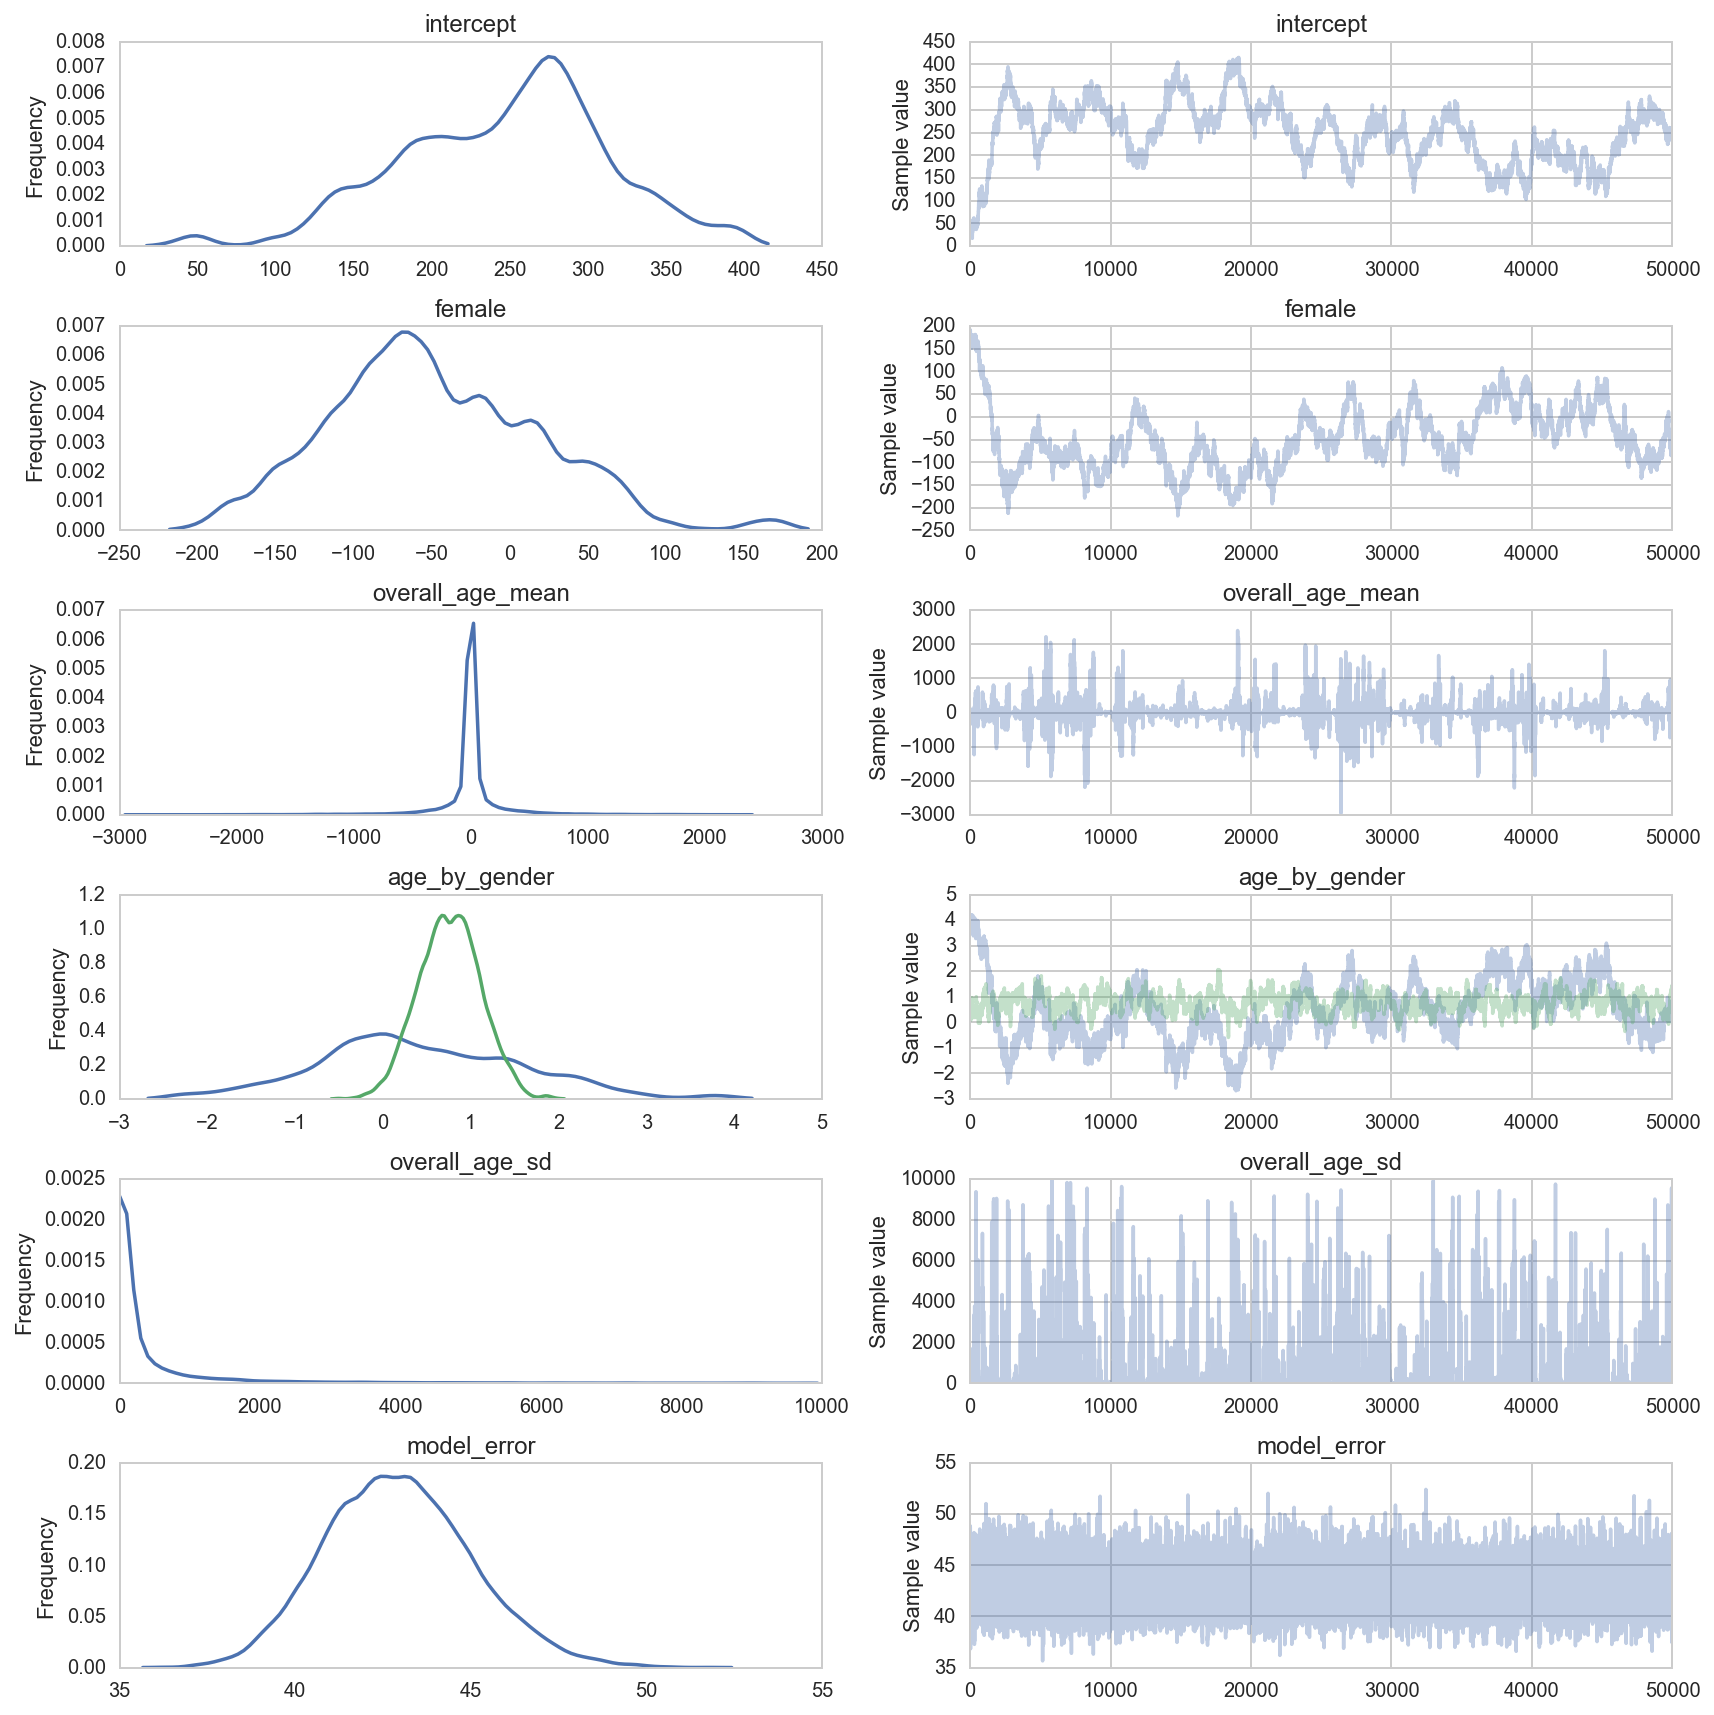

In [86]:
pm.traceplot(trace[100000:])